Using cuda device



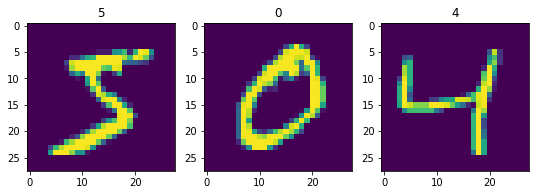

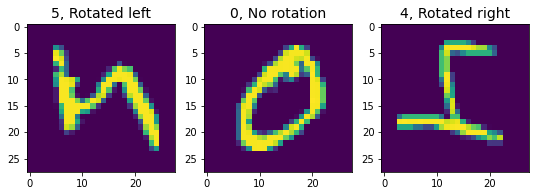

In [ ]:
"""
Set everything up:
import stuff
set to train with GPU
make datasets
plot some images
"""

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import normalize

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from random import randrange

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device\n")

#grab the mnist data using pytorch's vision library, torchvision
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
dataset3 = datasets.MNIST('../data', train=False,
                    transform=transform)

#train, test and validation
train_dataloader = DataLoader(dataset1, batch_size=8)
test_dataloader = DataLoader(dataset2, batch_size=64)
val_dataloader = DataLoader(dataset2, batch_size=64)

#let's look at some images / labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 18))
ax_arr = [ax1, ax2, ax3]

for i in range(3):
    img, label = dataset1.__getitem__(i)
    a = ax_arr[i]
    a.imshow(img.numpy().reshape([28,28]))
    a.set_title(label)

# let's try rotating the images
# left 90 deg, no rotation, right 90 deg
rots=[90,0,-90]
titles=["Rotated left", "No rotation", "Rotated right"]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 18))
ax_arr = [ax1, ax2, ax3]

for i in range(3):
    img, label = dataset1.__getitem__(i)
    img = TF.rotate(img,rots[i])
    a = ax_arr[i]
    a.imshow(img.numpy().reshape([28,28]))
    a.set_title(f"{label}, {titles[i]}", fontsize=14)

plt.savefig('rot_data.png')

In [ ]:
# Define model and compile it
WIDTH=32

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,WIDTH),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(WIDTH,3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(3,3),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        #reshape input
        x = x.view(-1, 28*28)
        logits = self.linear_relu_stack(x)
        return logits

model = Net().to(device)
print(model)
#define loss function and optimizer
#cross entropy loss because we are doing binary classification
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=3, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=3, out_features=3, bias=True)
    (10): Softmax(dim=1)
  )
)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Train the model using a specified
    data loader, loss function and optimizer
    """
    size = len(dataloader.dataset)
    model.train()
    history = []
    no_rot = 0
    left_rot = 0
    right_rot = 0
    count = 0

    #total correct for accuracy
    total_done = 0
    total_correct = 0

    for batch, (x, y) in enumerate(dataloader):

        x, y = x.to(device), y.to(device)

        choice = randrange(3)
        #rotate image
        if choice == 1:
            # 1/3rd of time we rotate left
            y = torch.tensor(np.zeros([y.shape[0]])).to(device)
            x = TF.rotate(x,90)
            left_rot += 1
        elif choice == 2:
            # 1/3rd of time we don't rotate
            y = torch.tensor(np.ones([y.shape[0]])).to(device)
            no_rot += 1
        else:
            # 1/3rd of time we rotate right
            y = torch.tensor(2*np.ones([y.shape[0]])).to(device)
            x = TF.rotate(x,-90)
            right_rot += 1

        # cast to proper datatype (long)
        y=y.type(torch.int64) 

        # Compute prediction error
        pred = model(x)

        # We compute this prediction error 
        loss = loss_fn(pred, y)

        # Backpropagation block
        # reset gradients to zero because by default we accumulate gradient 
        optimizer.zero_grad()
        # compute gradient of loss function using backprop
        loss.backward()
        # update parameters based on calculated gradient
        optimizer.step()

        # calculate accuracy 
        guesses = torch.argmax(pred, dim=1)
        correct = torch.sum(guesses==y).item()
        done = guesses.shape[0]
        total_correct += correct
        total_done += done
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            history.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        count += 1
    #average accuracy over training set during training
    acc = total_correct / total_done
    print("Data rotation proportions")
    print(left_rot, no_rot, right_rot)
    return acc, history

In [ ]:
def test_acc(dataloader, model, loss_fn):
    """
    Compute loss and accuracy of a model on some data
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_done = 0
    total_correct = 0
    test_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            choice = randrange(3)
            #rotate image
            if choice == 1:
                # 1/3rd of time we rotate left
                y = torch.tensor(np.zeros([y.shape[0]])).to(device)
                x = TF.rotate(x,90)
            elif choice == 2:
                # 1/3rd of time we don't rotate
                y = torch.tensor(np.ones([y.shape[0]])).to(device)
            else:
                # 1/3rd of time we rotate right
                y = torch.tensor(2*np.ones([y.shape[0]])).to(device)
                x = TF.rotate(x,-90)

            pred = model(x)
            # cast to proper datatype (long)
            y=y.type(torch.int64) 
            # We compute this prediction loss
            loss = loss_fn(pred, y)
            guesses = torch.argmax(pred, dim=1)
            correct = torch.sum(guesses==y).item()
            done = guesses.shape[0]
            total_correct += correct
            total_done += done
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    acc = total_correct / total_done
    return acc, test_loss

In [ ]:
"""
Train the model
Store training and validation loss and accuracy along the way
"""
epochs = 5
train_accs = []
train_losses = []
val_accs = []
val_losses = []
#initial val loss
val_acc, val_loss = test_acc(val_dataloader, model, loss_fn)
val_accs.append(val_acc)
val_losses.append(val_loss)
#initial training loss
train_acc, train_loss = test_acc(train_dataloader, model, loss_fn)
train_accs.append(train_acc)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_acc, t_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_accs.append(t_acc)
    train_losses.append(t_loss)
    v_acc, v_loss = test_acc(val_dataloader, model, loss_fn)
    val_accs.append(v_acc)
    val_losses.append(v_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.655499  [    0/60000]
loss: 0.690666  [  800/60000]
loss: 0.551445  [ 1600/60000]
loss: 0.697496  [ 2400/60000]
loss: 0.581831  [ 3200/60000]
loss: 0.689532  [ 4000/60000]
loss: 0.551702  [ 4800/60000]
loss: 0.557980  [ 5600/60000]
loss: 0.552139  [ 6400/60000]
loss: 0.551445  [ 7200/60000]
loss: 0.556915  [ 8000/60000]
loss: 0.551596  [ 8800/60000]
loss: 0.551446  [ 9600/60000]
loss: 0.807859  [10400/60000]
loss: 0.565676  [11200/60000]
loss: 0.675960  [12000/60000]
loss: 0.557650  [12800/60000]
loss: 0.557625  [13600/60000]
loss: 0.681563  [14400/60000]
loss: 0.559156  [15200/60000]
loss: 0.557703  [16000/60000]
loss: 0.675946  [16800/60000]
loss: 0.674888  [17600/60000]
loss: 0.551445  [18400/60000]
loss: 0.557386  [19200/60000]
loss: 0.675990  [20000/60000]
loss: 0.557841  [20800/60000]
loss: 0.557194  [21600/60000]
loss: 0.557196  [22400/60000]
loss: 0.551445  [23200/60000]
loss: 1.046010  [24000/60000]
loss: 0.569791  [24800/60000]


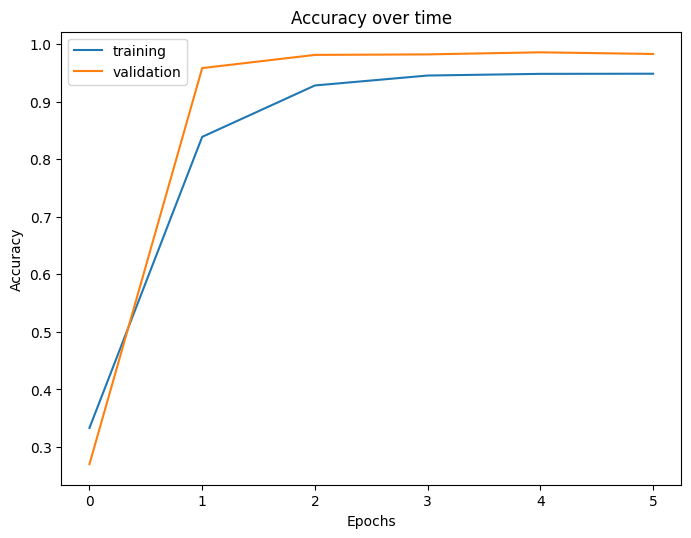

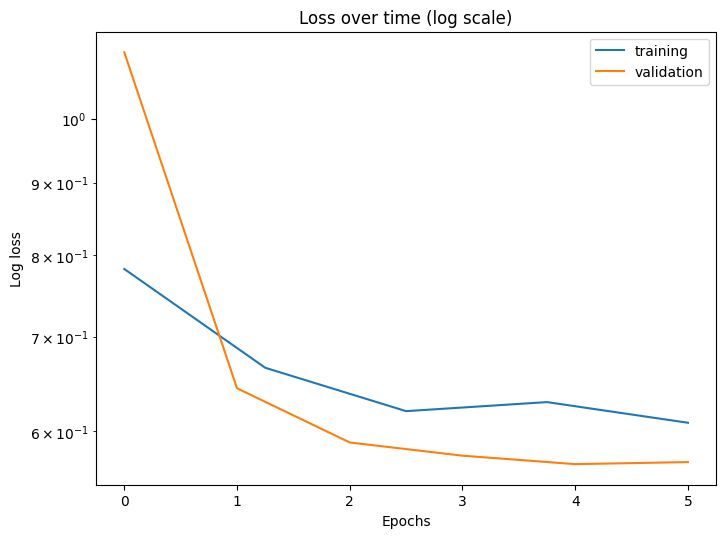

Accuracy:  0.984


In [ ]:
# PLOT ACCURACIES
train_accs = np.ravel(np.asarray(train_accs))
val_accs = np.reshape(val_accs,-1)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, num=len(train_accs))
x_v = np.linspace(0, epochs, num=len(val_accs))

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, train_accs,label="training")
plt.plot(x_v, val_accs,label="validation")
plt.yscale("linear")
plt.title("Accuracy over time")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('acc.png')
plt.show()

# PLOT LOSS
t_losses_final = np.ravel(np.mean(train_losses,axis=1))
val_losses_final = np.ravel(val_losses)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, len(t_losses_final))
x_v = np.linspace(0, epochs, len(val_losses_final))
fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, t_losses_final,label="training")
plt.plot(x_v, val_losses_final,label="validation")
plt.yscale("log")
plt.title("Loss over time (log scale)")
plt.ylabel("Log loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('log_loss.png')
plt.show()
"""
Given a build of the model, calculate test loss
"""
#test accuracy needs to be run with batch_size=1
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=True)
test_accuracy = test_acc(test_loader, model, loss_fn)
print("Accuracy: ", test_accuracy[0])

In [ ]:
print(t_losses_final.shape)
print(x_t.shape)

(381,)
(10,)
